In [10]:
# ECG Signal Classification Using MIT-BIH Dataset
!pip install wfdb
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [16]:
# STEP 1: Load ECG Data
# -----------------------------
record = wfdb.rdrecord('100', pn_dir='mitdb')
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')

signal = record.p_signal[:, 0]
fs = record.fs
annotation_symbols = annotation.symbol
annotation_samples = annotation.sample

In [17]:
# STEP 2: Preprocessing
# -----------------------------
def bandpass_filter(sig, lowcut=0.5, highcut=40.0, fs=360.0, order=2):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, sig)

filtered_signal = bandpass_filter(signal)
normalized_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)

In [18]:
# STEP 3: Feature Extraction
# -----------------------------
def extract_features(samples, symbols, sig, fs=360):
    features, labels = [], []
    for i in range(1, len(samples) - 1):
        rr_interval = (samples[i] - samples[i - 1]) / fs
        qrs_start = max(0, samples[i] - int(0.05 * fs))
        qrs_end = min(len(sig), samples[i] + int(0.05 * fs))
        qrs_width = (qrs_end - qrs_start) / fs
        morph = sig[qrs_start:qrs_end]
        feat = [
            rr_interval,
            qrs_width,
            np.max(morph),
            np.min(morph),
            np.mean(morph)
        ]
        features.append(feat)
        labels.append(symbols[i])
    return np.array(features), np.array(labels)

X, y = extract_features(annotation_samples, annotation_symbols, normalized_signal, fs)


In [19]:
# STEP 4: Label Encoding & Train-Test Split
# -----------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [20]:
# STEP 5: Train Random Forest Classifier
# -----------------------------
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


Classification Report:

              precision    recall  f1-score   support

           A       0.93      1.00      0.96        13
           N       1.00      1.00      1.00       669

    accuracy                           1.00       682
   macro avg       0.96      1.00      0.98       682
weighted avg       1.00      1.00      1.00       682



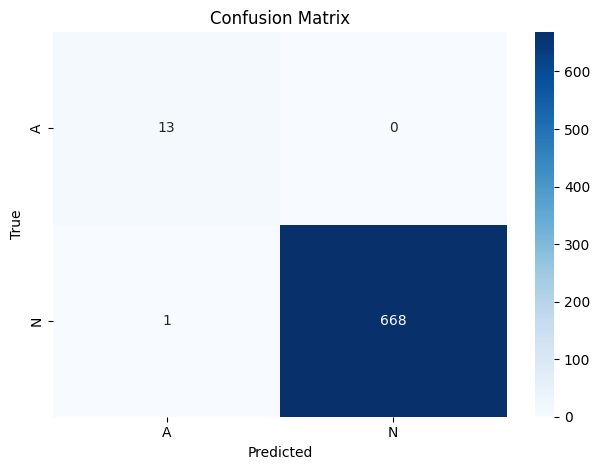

In [21]:
# STEP 6: Evaluate Model
# -----------------------------
print("\nClassification Report:\n")
# Get the unique labels in y_test
unique_labels = np.unique(y_test)

# Get the target names for the unique labels
target_names = le.classes_[unique_labels]

# Pass the unique labels and corresponding target names to classification_report
print(classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Update with unique labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()